어떻게 만들지?

- 딥러닝 기술
    - __"데이터 준비 → 딥러닝 네트워크 설계 → 학습 → 테스트(평가)"__의 순서대로 만들게 됩니다.

- Y가 범주형 데이터이므로 범주예측(분류), not 수치예측

# 5.2 데이터를 준비하자!

## MNIST 숫자 손글씨 Dataset 불러들이기

오늘은 텐서플로우(TensorFlow)의 표준 API인 tf.keras의 Sequential API를 이용하여 숫자 손글씨 인식기를 만들 거예요. 구글(Google)에서 오픈소스로 제공하는 텐서플로우는 가장 널리 사용되고 있는 머신러닝 라이브러리 중 하나입니다. 앞으로 딥러닝 구현 실습은 Tensorflow 버전 2.6.0에서 진행될 예정입니다.

자, 그럼 TF 2.6.0이 설치된 환경에서 먼저 다음의 코드를 실행해 봅시다. 앞으로 보게 될 코드의 구체적인 의미와 메커니즘은 이후에 더 자세하게 배우게 될 테니, 지금은 완벽하게 이해하지 못하더라도 마음 편하게 실행해 보세요.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import os


print(tf.__version__)                             # Tensorflow의 버전을 출력

mnist = keras.datasets.mnist

# MNIST 데이터를 로드. 다운로드하지 않았다면 다운로드까지 자동으로 진행됩니다. 
(x_train, y_train), (x_test, y_test) = mnist.load_data()   

print(len(x_train))  # x_train 배열의 크기를 출력

2.6.0
11501568/11490434 [==============================] - 0s 0us/step
60000


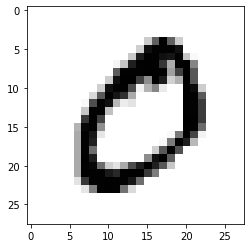

In [6]:
plt.imshow(x_train[1], cmap=plt.cm.binary)
plt.show()

In [8]:
y_train[1]          # 정답지이므로 digit으로 저장되어 있음, not image

0

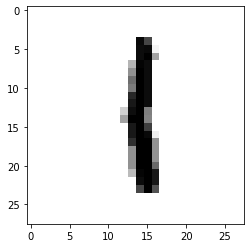

35001 번째 이미지의 숫자는 바로  1 입니다.


In [12]:
# index에 0에서 59999 사이 숫자를 지정해 보세요.
index=35000     
plt.imshow(x_train[index],cmap=plt.cm.binary)
plt.show()
print( (index+1), '번째 이미지의 숫자는 바로 ',  y_train[index], '입니다.')

## 학습용 데이터와 시험용 데이터



MNIST 데이터셋은 약 500명 사용자가 작성한 숫자 이미지를 가지고 있습니다. 그 중 250여명의 데이터가 학습용 데이터로, 다른 250여명의 데이터가 시험용 데이터로 이용됩니다.
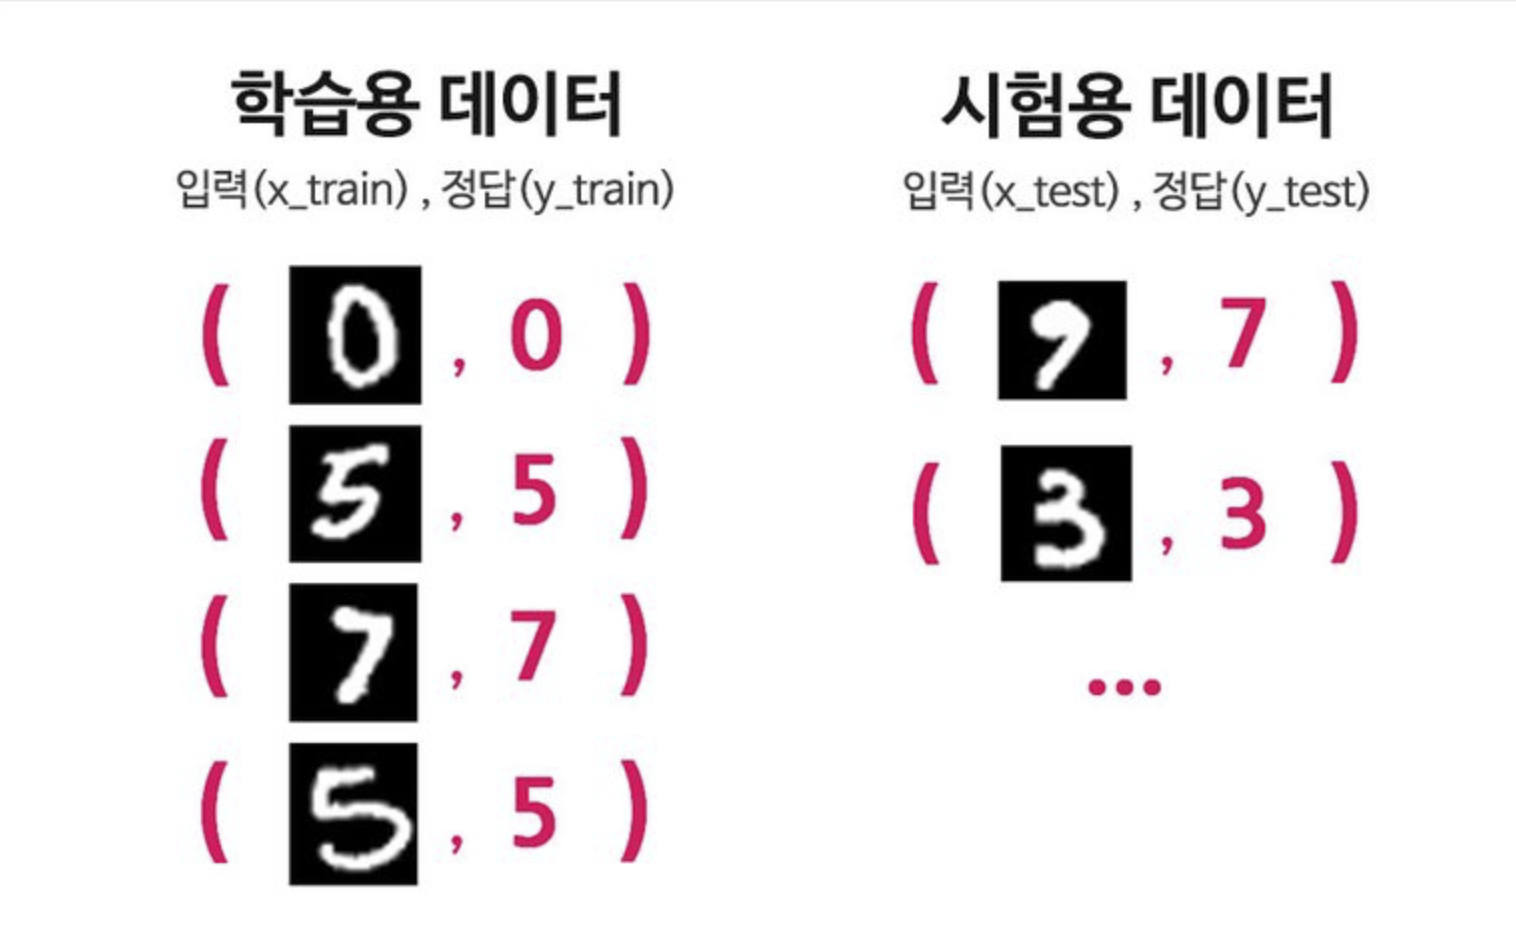


In [14]:
# 훈련용 데이터 크기 확인
x_train.shape

(60000, 28, 28)

아마도 (60000,28,28) 이라는 값을 보실 수 있을 겁니다. 이것은 28x28 크기의 숫자 이미지가 60,000장이 있다는 뜻인데요. 마찬가지로 시험용 데이터의 개수를 확인하고 싶다면 아래 코드를 실행하면 됩니다.

In [15]:
# 테스트 데이터 크기 확인
x_test.shape

(10000, 28, 28)

### Train, Validation, Test DataSet 차이
[Train, Validation, Test DataSet 차이](https://ganghee-lee.tistory.com/38)


- Train Dataset
    - 모델을 학습하기 위한 dataset이다. 한 가지 계속 명심해야할 중요한 사실은 "모델을 학습하는데에는 오직 유일하게 Train dataset만 이용한다"
    - 보통 train set을 이용해 각기 다른 모델을 서로 다른 epoch로 학습을 시킨다.
    - 여기서 각기 다른 모델이란 hidden layer 혹은 hyper parameter에 약간씩 변화를 줌을 뜻한다.
- validation set은 학습이 이미 완료된 모델을 검증하기위한 dataset이다.
    - 언제 검증용 데이터(validation set)를 사용하나요?
        - 머신러닝 학습 과정이 정상적으로 진행되고 있는지
        - 오버피팅이 발생하고 있지 않은지
        - 학습을 중단해도 되는지 등을 확인하고 싶을 때
- test set은 학습과 검증이 완료된 모델의 성능을 평가하기위한 dataset이다.



validation set과 test set의 공통점은 이 데이터를 통해 모델을 update 즉, 학습을 시키지 않는다는 것이다.
이렇게 validation set과 test set은 둘다 이미 학습을 완료한 모델에 대해 평가하고 학습을 시키지 않는데
결론부터 말하자면 둘의 차이는 
Validation set은 모델을 update, 즉 학습을 시키진 않지만 학습에 '관여'는 한다.
Test set은 학습에 전혀 관여하지 않고 오직 '최종 성능'을 평가하기 위해 쓰인다.

### 교차검증이란

교차 검증이란 쉽게 말해 데이터를 여러 번 반복해서 나누고 여러 모델을 학습하여 성능을 평가하는 방법이다. 이렇게 하는 이유는 데이터를 학습용/평가용 데이터 세트로 여러 번 나눈 것의 평균적인 성능을 계산하면, 한 번 나누어서 학습하는 것에 비해 일반화된 성능을 얻을 수 있기 때문이다. 이 때문에 교차 검증은 기존 대비 안정적이고 뛰어난 통계적 평가 방법으로 평가받는다.
<img src=https://imghub.insilicogen.com/media/photos/cv.png>


## 데이터 전처리 하기
숫자 손글씨 이미지의 실제 픽셀 값은 0~255 사이의 값을 가집니다

In [16]:
print('최소값:',np.min(x_train), ' 최대값:',np.max(x_train))

최소값: 0  최대값: 255


### 정규화하기
인공지능 모델을 훈련시키고 사용할 때, 일반적으로 입력은 0-1 사이의 값으로 정규화 시켜주는 것이 좋습니다. MNIST 데이터는 각 픽셀의 값이 0-255 사이 범위에 있으므로 데이터들을 255.0 으로 나누어주면 됩니다. 최소값이 0, 최대값이 1에 근접하도록 나오는지 확인해 봅시다.

- Min-Max 정규화
    - 최소 최대값의 차이를 나눠주면 최소값은 0 최대값은 1이 됨

In [17]:
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0
print('최소값:',np.min(x_train_norm), ' 최대값:',np.max(x_train_norm))

최소값: 0.0  최대값: 1.0


# 5-3. 딥러닝 네트워크 설계하기

## Sequential Model을 사용해 보자
데이터가 모두 준비가 되었다면 이제는 딥러닝 네트워크를 만들어야 합니다. 이번 수업에서는 텐서플로우 케라스(tf.keras)에서 Sequential API라는 방법을 사용할 겁니다. Sequential API는 개발의 자유도는 많이 떨어지지만, 매우 간단하게 딥러닝 모델을 만들어낼 수 있는 방법입니다. 여러분들은 이 방법을 통해 미리 정의된 딥러닝 레이어(layer)를 손쉽게 추가할 수 있습니다.

케라스에서 모델을 만드는 방법은 Sequential API 외에도 Functional API를 이용하는 방법, 밑바닥부터 직접 코딩하는 방법 등 여러 방법이 있습니다. 공부하면서 하나씩 배워나갈 테니 걱정 마세요 :)

이번 수업의 목적은 여러분들에게 딥러닝 네트워크의 모든 것을 가르치는 것이 아닙니다. 빠르게 다양한 응용 예들을 접해보고, 주어진 코드를 다른 데이터에 활용을 해보는 경험을 전달해 드리는 것이 그 목적입니다. 따라서 코드의 내용이 당장 이해가 안 가더라도 부담가지지 않으셔도 됩니다. 최대한 이해를 하려 노력은 하되, 프로그램 수행 결과에서 재미를 느끼는 것이 무엇보다도 중요합니다.

다음의 코드는 tf.keras의 Sequential API를 이용하여 LeNet이라는 딥러닝 네트워크를 설계한 예입니다. 8줄밖에 안되는 간단한 코드이지만, 손글씨 숫자 분류기를 구현하는 데는 충분합니다.

In [29]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,1)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))


print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  7


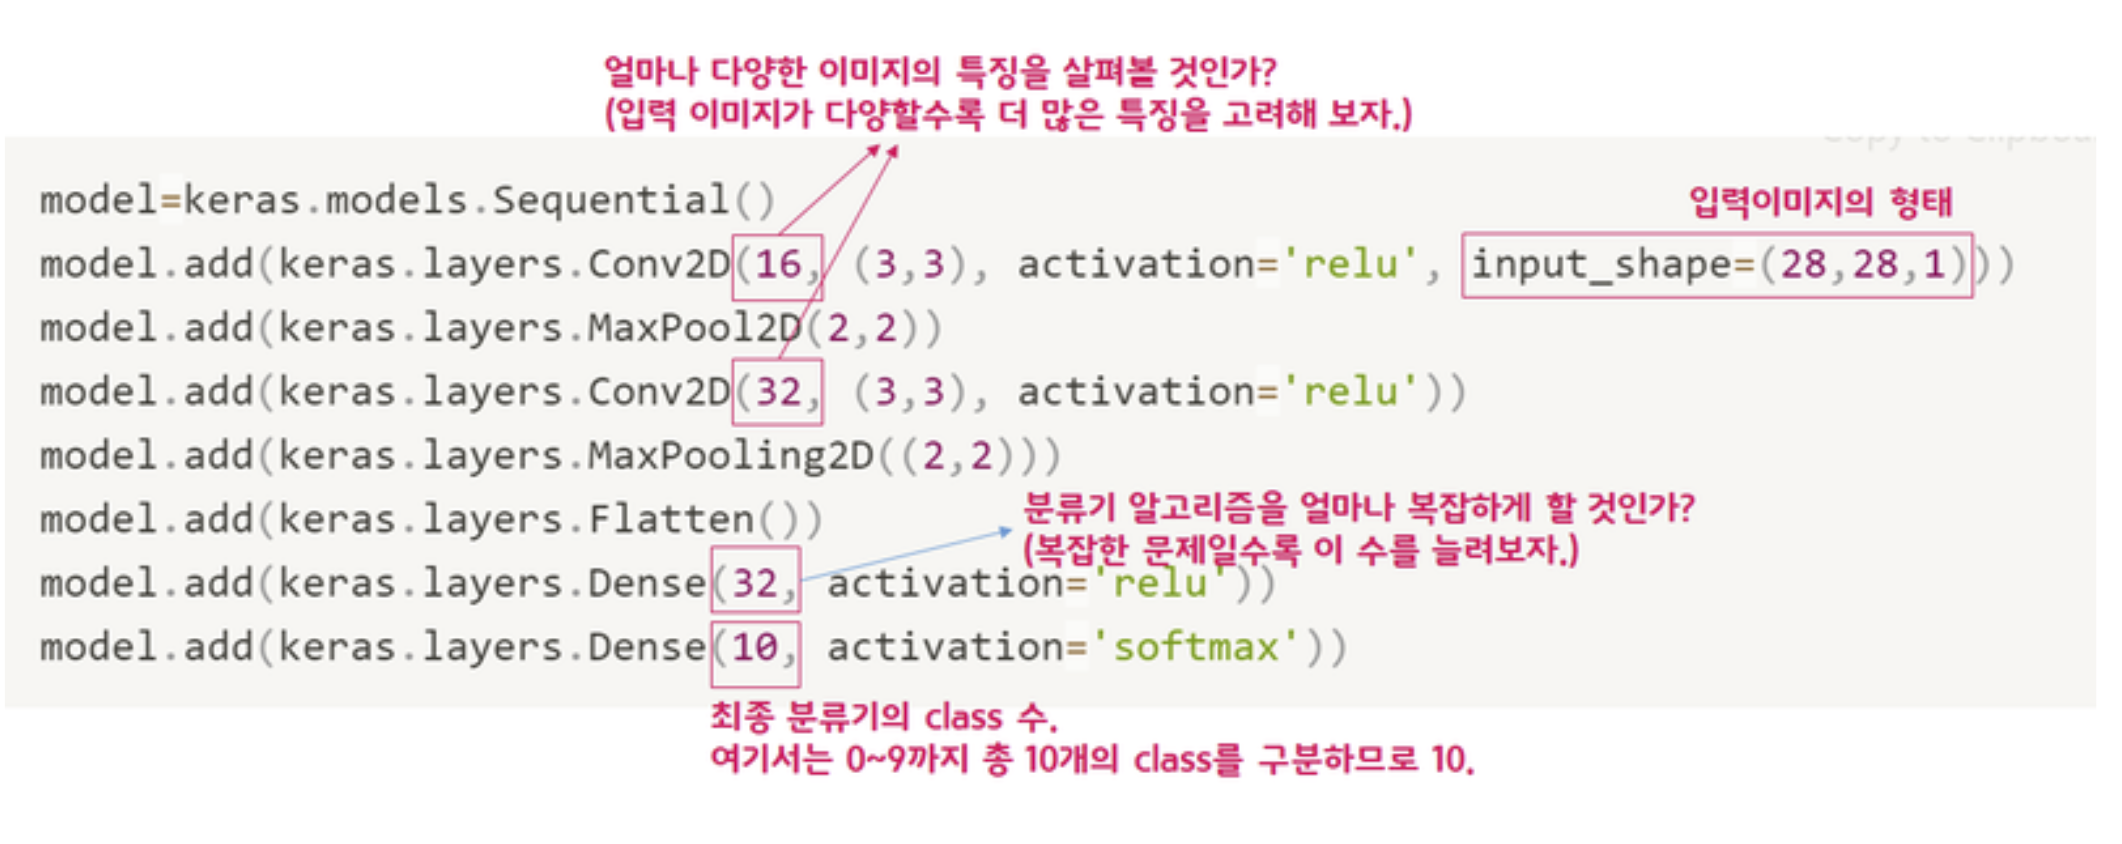

- Conv2D 레이어의 첫 번째 인자는 사용하는 이미지 특징의 수(정확하게는 __필터의 수__)입니다. 여기서는 16과 32를 사용했습니다. 가장 먼저 16개의 이미지 특징을, 그 뒤에 32개의 이미지 특징씩을 고려하겠다는 뜻입니다.
 우리의 숫자 이미지는 사실 매우 단순한 형태의 이미지입니다. 만약 강아지 얼굴 사진이 입력 이미지라면 훨씬 디테일하고 복잡한 영상일 것입니다. 그럴 경우에는 이 특징 숫자를 늘려주는 것을 고려해 볼 수 있습니다.
- Dense 레이어의 첫 번째 인자는 분류기에 사용되는 __뉴런의 숫자__ 입니다. 이 값이 클수록 보다 복잡한 분류기를 만들 수 있습니다. 10개의 숫자가 아닌 알파벳을 구분하고 싶다면, 대문자 26개, 소문자 26개로 총 52개의 클래스를 분류해 내야 합니다. 그래서 32보다 큰 64, 128 등을 고려해 볼 수 있을 것입니다.
- 마지막 Dense 레이어의 뉴런 숫자는 결과적으로 분류해 내야 하는 클래스 수로 지정하면 됩니다. 숫자 인식기에서는 10, 알파벳 인식기에서는 52가 되겠지요.

5번째 스텝인 얼마나 잘 만들었는지 확인하기에서 이 코드를 수정해 볼 것입니다. 지금은 일단 실행하는 데 초점을 맞춥시다.

우리가 만든 딥러닝 네트워크 모델을 확인해 보려면, model.summary() 메소드를 이용하면 됩니다.

In [30]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25632     
_________________________________________________________________
dense_1 (Dense)              (None, 10)               

# 5-4. 딥러닝 네트워크 학습시키기

우리가 만든 네트워크의 입력은 (데이터갯수, 이미지 크기 x, 이미지 크기 y, 채널수) 와 같은 형태를 가집니다. 이전 스텝에서 첫 번째 레이어에 input_shape=(28,28,1)로 지정했던 것을 기억하시나요?
그런데 print(x_train.shape) 을 해보면, (60000, 28, 28) 로 채널수에 대한 정보가 없습니다. 따라서 (60000, 28, 28, 1) 로 만들어 주어야 합니다 (여기서 채널수 1은 흑백 이미지를 의미합니다. 컬러 이미지라면 R, G, B 세 가지 값이 있기 때문에 3이겠죠?).

In [39]:
print(f"Before Reshape - x_train_norm shape: {x_train_norm.shape}")
print(f"Before Reshape - x_test_norm shape: {x_test_norm.shape}")

x_train_reshaped=x_train_norm.reshape( -1, 28, 28, 1)  # 데이터갯수에 -1을 쓰면 reshape시 자동계산됩니다.
x_test_reshaped=x_test_norm.reshape( -1, 28, 28, 1)

print(f"After Reshape - x_train_reshaped shape: {x_train_reshaped.shape}")
print(f"After Reshape - x_test_reshaped shape: {x_test_reshaped.shape}")

Before Reshape - x_train_norm shape: (60000, 28, 28)
Before Reshape - x_test_norm shape: (10000, 28, 28)
After Reshape - x_train_reshaped shape: (60000, 28, 28, 1)
After Reshape - x_test_reshaped shape: (10000, 28, 28, 1)


그러면 이제 x_train 학습 데이터로 딥러닝 네트워크를 학습시켜 봅시다. 여기서 epochs=10 은 전체 60,000개의 데이터를 10번 반복 사용해서 학습을 시키라는 뜻입니다. 물론 model의 입력 정의에 형태를 맞춘 x_train_reshaped가 사용되어야겠죠. 자 그러면 코드를 실행해 봅시다.

## 학습시키기

In [40]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_reshaped, y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.1945 - accuracy: 0.9413
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0630 - accuracy: 0.9804
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0446 - accuracy: 0.9862
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0345 - accuracy: 0.9893
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0289 - accuracy: 0.9905
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0229 - accuracy: 0.9933
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0188 - accuracy: 0.9938
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0159 - accuracy: 0.9950
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0131 - accuracy: 0.9957
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.012

# 5-5. 얼마나 잘 만들었는지 확인하기

## 테스트 데이터로 성능을 확인해 보자

사실 위의 인식 정확도는 학습용 데이터(x_train)을 가지고 구한 것입니다. 즉, 연습문제를 잘푸는 인공지능을 만든 거죠. 우리가 만든 딥러닝 네트워크는 실제 시험도 잘 볼 수 있을까요?
자 그러면 시험용 데이터(x_test)를 가지고 확인해 봅시다.

In [41]:
test_loss, test_accuracy = model.evaluate(x_test_reshaped,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

313/313 - 1s - loss: 0.0377 - accuracy: 0.9896
test_loss: 0.03772464767098427
test_accuracy: 0.9896000027656555


결과가 어떻게 나오나요? 99.57점을 받을 줄 알았는데, 98.85로 시험점수가 소폭 하락했네요. (학습할 때마다 test_loss, test_accuracy 도 변동됩니다.) 역시 연습문제보다 실제 시험문제가 더 어려운가 봅니다. 위 MNIST 데이터셋 참고문헌을 보시면 학습용 데이터와 시험용 데이터의 손글씨 주인이 다른 것을 알 수 있습니다. 즉, 한 번도 본 적이 없는 필체의 손글씨가 섞여 있을 가능성이 높습니다. 어찌 보면 인식률이 떨어지는 것은 어느 정도 예상 가능한 일이었습니다.

## 어떤 데이터를 잘못 추론했을까? 눈으로 확인해 보자
model.evaluate() 대신 model.predict()를 사용하면 model이 입력값을 보고 실제로 추론한 확률분포를 출력할 수 있습니다. 우리가 만든 model이란 사실 10개의 숫자 중 어느 것일지에 대한 확률값을 출력하는 함수입니다. 이 함수의 출력값, 즉 확률값이 가장 높은 숫자가 바로 model이 추론한 숫자가 되는 거죠.

In [49]:
predicted_result = model.predict(x_test_reshaped)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=0  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

model.predict() 결과 :  [6.7873486e-18 1.0578406e-13 2.4891246e-13 1.7818406e-10 2.0870953e-11
 1.4439667e-14 2.7942678e-20 1.0000000e+00 2.6611591e-11 1.8776783e-10]
model이 추론한 가장 가능성이 높은 결과 :  7
실제 데이터의 라벨 :  7


model.predict() 결과가 [9.5208375e-15 2.8931768e-11 1.2696462e-09 2.0265421e-08 6.1321614e-11 2.9599554e-12 1.0710074e-15 1.0000000e+00 1.0549885e-11 3.8589491e-08] 와 같이 벡터 형태로 나왔나요? 이 벡터는 model이 추론한 결과가 각각 0, 1, 2, ..., 7, 8, 9일 확률을 의미합니다.

이 경우라면 model이 추론한 결과가 7일 확률이 1.00에 근접하고 있다, 즉 이 model은 입력한 이미지가 숫자 7이라는 걸 아주 확신하고 있다는 뜻이 됩니다.

정말 숫자 7인가요?

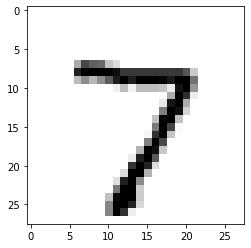

In [50]:
plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

그렇다면 model이 추론해 낸 숫자와 실제 라벨의 값이 다른 경우는 어떤 경우인지 직접 확인해 볼 수도 있겠습니다.


예측확률분포: [2.2816951e-09 1.6198134e-13 3.7574094e-10 1.1233339e-08 2.5431395e-12
 7.1670347e-01 2.8315982e-01 8.9847781e-16 1.3666587e-04 1.0471605e-11]
라벨: 6, 예측결과: 5


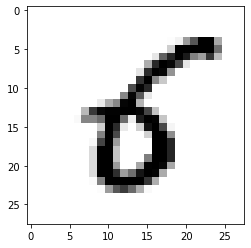

예측확률분포: [9.9858910e-01 2.1708507e-08 2.7409939e-07 3.3634501e-06 9.3842252e-12
 1.3169609e-03 8.9376968e-05 2.7611935e-07 5.2391249e-07 1.2782974e-07]
라벨: 5, 예측결과: 0


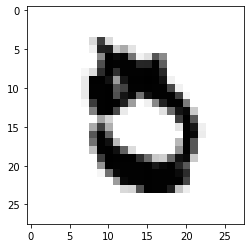

예측확률분포: [3.1007617e-06 7.0656232e-09 1.0467126e-07 1.8406406e-10 4.7787090e-08
 4.8595661e-01 5.1399058e-01 1.5700179e-09 3.9992547e-06 4.5539771e-05]
라벨: 5, 예측결과: 6


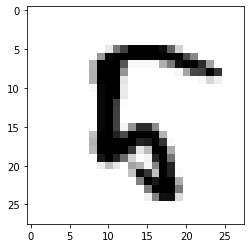

예측확률분포: [1.9120971e-17 4.2897103e-08 4.5735802e-12 1.2650719e-04 1.0552759e-09
 9.9972981e-01 1.8770706e-14 1.1628587e-06 1.4158733e-04 8.7765943e-07]
라벨: 3, 예측결과: 5


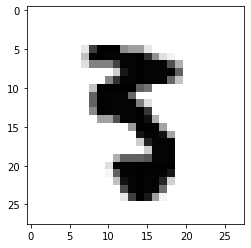

예측확률분포: [2.0062271e-06 3.5538789e-10 6.8047601e-01 2.4177305e-07 5.5133051e-11
 4.6042176e-12 7.5543150e-15 3.1950870e-01 6.9273989e-07 1.2342543e-05]
라벨: 7, 예측결과: 2


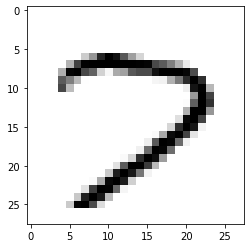

In [51]:
import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다. 
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 5개만 뽑아봅시다.
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()

틀린 경우를 살펴보면 model도 추론 결과에 대한 확신도가 낮고 매우 혼란스러워 한다는 것을 알 수 있습니다. model의 추론 결과를 시각화하여 살펴보는 것은 향후 model 성능 개선에 도움이 되는 아이디어를 얻을 수 있는 좋은 방법 중 하나입니다.

# 5-6. 더 좋은 네트워크 만들어 보기

그러면 인식률을 99점대로 만들 수 없을까요? 딥러닝 네트워크의 구조 자체는 바꾸지 않으면서도 우리가 해볼 수 있는 것들이 있습니다. 3번째 스텝 딥러닝 네트워크 설계하기에서 살펴본 하이퍼파라미터들을 바꾸어 보는 것인데요. Conv2D 레이어에서 입력 이미지의 특징 수를 늘리거나 줄여 보거나, Dense 레이어에서 뉴런수를 바꾸어 보거나, 학습 반복 횟수인 epoch 값을 변경해 볼 수 있을 겁니다.

In [53]:
# 바꿔 볼 수 있는 하이퍼파라미터들
n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,1)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_train_reshaped, y_train, epochs=n_train_epoch)

# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=2)
print(f"test_loss: {test_loss} ")
print(f"test_accuracy: {test_accuracy}")

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                25632     
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [54]:
# 바꿔 볼 수 있는 하이퍼파라미터들
n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=150

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,1)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_train_reshaped, y_train, epochs=n_train_epoch)

# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=2)
print(f"test_loss: {test_loss} ")
print(f"test_accuracy: {test_accuracy}")

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                25632     
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

1875/1875 [==============================] - 5s 2ms/step - loss: 3.7484e-08 - accuracy: 1.0000
Epoch 146/150
1875/1875 [==============================] - 5s 2ms/step - loss: 1.9598e-08 - accuracy: 1.0000
Epoch 147/150
1875/1875 [==============================] - 5s 3ms/step - loss: 1.1025e-08 - accuracy: 1.0000
Epoch 148/150
1875/1875 [==============================] - 5s 2ms/step - loss: 5.8730e-09 - accuracy: 1.0000
Epoch 149/150
1875/1875 [==============================] - 5s 3ms/step - loss: 2.9802e-09 - accuracy: 1.0000
Epoch 150/150
1875/1875 [==============================] - 5s 2ms/step - loss: 1.6650e-09 - accuracy: 1.0000
313/313 - 1s - loss: 0.1536 - accuracy: 0.9909
test_loss: 0.1536201387643814 
test_accuracy: 0.9908999800682068


# 5-7. 미니 프로젝트 : 가위바위보 분류기를 만들자

In [56]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


## 데이터를 준비하자

가위 바위 보 사진 데이터 찍고 데이터 준비

- $ mkdir -p ~/aiffel/rock_scissor_paper/scissor  

- $ mkdir -p ~/aiffel/rock_scissor_paper/rock  

- $ mkdir -p ~/aiffel/rock_scissor_paper/paper

### Reshape - PIL 라이브러리

In [58]:
from PIL import Image
import glob
import os

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


### 데이터 불러오기 + Resize 하기

숫자 손글씨의 경우 이미지 크기가 28x28 이었기 때문에, 우리의 가위, 바위, 보 이미지도 28x28로 만들어야 합니다. 이를 위해서는 PIL 라이브러리를 사용해볼 거예요. 그러려면 먼저 라이브러리를 불러와야 겠죠?

In [67]:
# 리사이즈 28 x 28 - 가위
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

214  images to be resized.
214  images resized.
가위 이미지 resize 완료!


In [68]:
# 리사이즈 28 x 28 - 바위 
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock/rock"
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")

212  images to be resized.
212  images resized.
바위 이미지 resize 완료!


In [69]:
# 리사이즈 28 x 28 - 보
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper/paper"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

246  images to be resized.
246  images resized.
보 이미지 resize 완료!


### 이미지 로드하기

- 데이터 로드
    - 숫자 손글씨 인식기는 mnist.load_data() 라는 함수로 데이터를 읽었던 것 기억하시죠? 
    - 여러분들이 아직 코딩에 익숙하지 않을 수 있으므로, 가위, 바위, 보 데이터를 읽을 수 있는 load_data() 함수를 만들어 드릴 거예요. 
    - 이 코드를 활용하면 임의의 사진 데이터(ex. 귤이 잘 익었나, 안 익었나? 웃는 얼굴인가, 우는 얼굴인가, 평범한 표정의 얼굴인가? 등)에 적용하실 수 있을 겁니다.

- load_data(경로) 
- 숫자 손글씨는 0~9 까지의 클래스가 있었던 것 기억하시죠? 가위바위보의 경우 3개의 클래스 즉, 가위: 0, 바위: 1, 보: 2 로 라벨링이 될 것입니다.

In [72]:
import numpy as np

def load_data(img_path, number_of_data=672):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data * img_size * img_size * color, dtype = np.int32).reshape(number_of_data, img_size, img_size, color)
    labels=np.zeros(number_of_data, dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path + '/scissor/scissor/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:] = img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 0          # 가위 : 0
        idx = idx + 1

    for file in glob.iglob(img_path + '/rock/rock/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:] = img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 1          # 바위 : 1
        idx = idx + 1  
    
    for file in glob.iglob(img_path + '/paper/paper/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 2          # 보 : 2
        idx = idx + 1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train) = load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 672 입니다.
x_train shape: (672, 28, 28, 3)
y_train shape: (672,)


라벨:  0


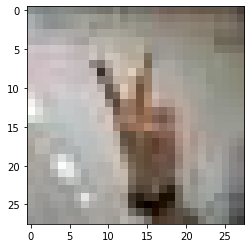

In [73]:
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

## 딥러닝 네트워크 설계하기

In [108]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# model을 직접 만들어 보세요.
# Hint! model의 입력/출력부에 특히 유의해 주세요. 가위바위보 데이터셋은 MNIST 데이터셋과 어떤 점이 달라졌나요?
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))


print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  9
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 3, 3, 64)          18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_11 (Flatten)         

## 딥러닝 네트워크 학습시키기

In [109]:
# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.compile()과 model.fit()을 사용해 봅시다.
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=8)

Epoch 1/8
21/21 [==============================] - 0s 3ms/step - loss: 3.8807 - accuracy: 0.4196
Epoch 2/8
21/21 [==============================] - 0s 3ms/step - loss: 0.9508 - accuracy: 0.6205
Epoch 3/8
21/21 [==============================] - 0s 3ms/step - loss: 0.5355 - accuracy: 0.7619
Epoch 4/8
21/21 [==============================] - 0s 3ms/step - loss: 0.3344 - accuracy: 0.8735
Epoch 5/8
21/21 [==============================] - 0s 3ms/step - loss: 0.2131 - accuracy: 0.9375
Epoch 6/8
21/21 [==============================] - 0s 3ms/step - loss: 0.1292 - accuracy: 0.9643
Epoch 7/8
21/21 [==============================] - 0s 3ms/step - loss: 0.0826 - accuracy: 0.9851
Epoch 8/8
21/21 [==============================] - 0s 3ms/step - loss: 0.0523 - accuracy: 0.9940


## 얼마나 잘 만들었는지 확인하기(테스트)

여러분들은 300장의 가위바위보 이미지를 만들어 모두 학습에 사용했습니다. 그러므로 테스트 데이터가 없죠. 옆 친구의 이미지 데이터 300장을 받아오세요. 그리고 그것을 테스트 데이터로 하여 test accuracy를 측정해보세요. (만약 웹캠이 없는 경우 섹션을 진행하신 경우, 이미 test 데이터셋이 준비돼있으니 친구에게 조르지 않으셔도 됩니다)

In [82]:

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test_for/paper"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

1137  images to be resized.
1137  images resized.
가위 이미지 resize 완료!


In [84]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test_for/rock"
resize_images(image_dir_path)
print("바위 이미지 resize 완료!")

1111  images to be resized.
1111  images resized.
가위 이미지 resize 완료!


In [85]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test_for/scissor"
resize_images(image_dir_path)
print("가위 이미지 resize 완료!")

1153  images to be resized.
1153  images resized.
가위 이미지 resize 완료!


In [110]:
import numpy as np

def load_data(img_path, number_of_data=3401):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data * img_size * img_size * color, dtype = np.int32).reshape(number_of_data, img_size, img_size, color)
    labels=np.zeros(number_of_data, dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path + '/scissor/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:] = img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 0          # 가위 : 0
        idx = idx + 1

    for file in glob.iglob(img_path + '/rock/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:] = img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 1          # 바위 : 1
        idx = idx + 1  
    
    for file in glob.iglob(img_path + '/paper/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 2          # 보 : 2
        idx = idx + 1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test_for"
(x_test, y_test) = load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_train)의 이미지 개수는 3401 입니다.
x_test shape: (3401, 28, 28, 3)
y_test shape: (3401,)


In [111]:
# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f"test_loss: {test_loss} ")
print(f"test_accuracy: {test_accuracy}")

107/107 - 0s - loss: 2.5936 - accuracy: 0.3869
test_loss: 2.5936412811279297 
test_accuracy: 0.3869450092315674


## 어떤 데이터를 잘못 추론했을까? 눈으로 확인해 보자

model.evaluate() 대신 model.predict()를 사용하면 model이 입력값을 보고 실제로 추론한 확률분포를 출력할 수 있습니다. 우리가 만든 model이란 사실 10개의 숫자 중 어느 것일지에 대한 확률값을 출력하는 함수입니다. 이 함수의 출력값, 즉 확률값이 가장 높은 숫자가 바로 model이 추론한 숫자가 되는 거죠.

In [113]:
predicted_result = model.predict(x_test)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)  # 최대값의 인덱스를 뽑는다

idx=0  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

model.predict() 결과 :  [0.27803025 0.67107415 0.05089558]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  0


In [117]:
np.argmax(predicted_result, axis=1)

array([1, 1, 1, ..., 1, 1, 0])

In [115]:
predicted_result

array([[2.7803025e-01, 6.7107415e-01, 5.0895579e-02],
       [1.2761322e-01, 8.1675571e-01, 5.5631038e-02],
       [2.0202969e-03, 9.9698323e-01, 9.9639618e-04],
       ...,
       [1.8240556e-01, 6.4467037e-01, 1.7292407e-01],
       [8.5875064e-02, 8.9955497e-01, 1.4569975e-02],
       [8.8367695e-01, 6.0249196e-04, 1.1572067e-01]], dtype=float32)